In [1]:
import re
import time
from pathlib import Path

import librosa as lbr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import scipy.signal
from tqdm.notebook import tqdm
tqdm.pandas()

from rich.progress import track

2024-04-12 15:27:51.228001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 15:27:51.228158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 15:27:51.260538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 15:27:51.330216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:27:52.249622: W tensorflow/compiler/tf2

In [2]:
data_dir = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/data/original/training-dataset")
gen_dir  = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/generation")

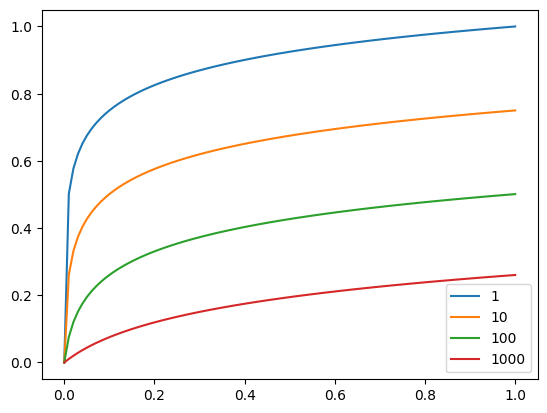

In [32]:
for i in range(0, 4):
    x = np.linspace(0, 1, 100)
    plt.plot(x, (np.log10(x/10**i + 1e-4) + 4)/4, label=10**i)
plt.legend()

0.0 1.0


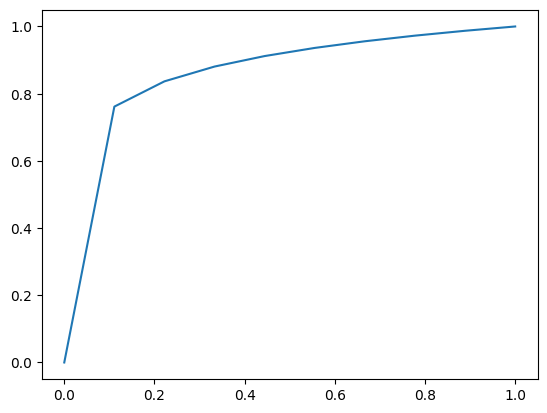

In [33]:
s = np.linspace(0, 1, 10)
r = 1
a = 1e-4
v = (np.log10(s/r + a) - np.log10(a)) / (np.log10(1/r + a) - np.log10(a))
v = np.log10(s / (r*a) + 1) / np.log10(1 / (r*a) + 1)
plt.plot(s, v)
print(v.min(), v.max())

## Load real syllables

In [3]:
def get_spec(df, feat="s"):
    return np.dstack(df[feat].values)
    
def get_features(df, feat="s"):
    return np.concatenate(get_spec(df, feat=feat)).T

In [4]:
from joblib import delayed, Parallel

sr = 16000
max_length = round(sr * 0.3)
n_per_class = 1000

In [5]:
def make_spectrogram(x):
    _, _, s = scipy.signal.spectrogram(x, fs=16000, window='hann', nperseg=256, noverlap=128, nfft=1024, return_onesided=True, scaling='spectrum', axis=-1, mode='magnitude')
    # s = lbr.stft(x, hop_length=128, win_length=256, n_fft=1024)
    # return lbr.power_to_db(np.abs(s)**2, amin=1e-4, ref=np.max)
    ref = 1
    amin = 1e-4
    np.log10(s / (ref*amin) + 1) / np.log10(1 / (ref*amin) + 1)
    return s

def make_melspectrogram(x):
    s = make_spectrogram(x)
    return lbr.feature.melspectrogram(S=s, sr=16000, n_mels=128, fmax=8000, fmin=500)

def make_spectrogram2(x):
    s = lbr.stft(x, hop_length=128, win_length=256, n_fft=1024)
    return np.log(1 + 100 * np.abs(s**2))  # Silvia's recipe

def make_mfcc(x):
    s = make_melspectrogram(x)
    s = lbr.feature.mfcc(S=s, sr=16000, hop_length=128, win_length=256, n_fft=1024, n_mfcc=13)
    d = lbr.feature.delta(s)
    return s
    
def preprocess(files, max_length, load=True, sr=16000, kind="mfcc"):
    @delayed
    def load(f):
        if load:
            y = lbr.load(f, sr=sr)[0]

        else:
            y = f
        y = lbr.util.normalize(y)
        # sos = scipy.signal.butter(5, 500, btype='high', output='sos', fs=sr)
        # y = scipy.signal.sosfiltfilt(sos, y)
        if kind == "mfcc":
            return make_mfcc(y[:max_length])
        elif kind == "spec":
            return make_spectrogram(y[:max_length])
        elif kind == "spec2":
            return make_spectrogram2(y[:max_length])
        elif kind == "mel":
            return make_melspectrogram(y[:max_length])
        else:
            raise NotImplementedError(kind)
    
    results = Parallel(n_jobs=-1)(load(f) for f in files)

    return results

In [11]:
files = list(data_dir.rglob("**/*.wav"))

data_table = {
    "file": files,
    "label": [f.parent.name for f in files],
    "sr": 16000,
    "kind": "real",
}

rdf = pd.DataFrame(data_table)
rdf = rdf.groupby("label").sample(n_per_class, replace=False)

rdf["s"] = preprocess(track(rdf.file), max_length, kind="mfcc")
rdf["spec"] = preprocess(tqdm(rdf.file), max_length, kind="mel")

rdf = rdf.sort_values(by=["label", "file"]).reset_index(drop=True)

rdf["y"] = rdf["label"]

display(rdf.head())
display(rdf.info())

Output()

  0%|          | 0/16000 [00:00<?, ?it/s]

,file,label,sr,kind,s,spec,y
0,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.0037103724, 0.011327581, 0.005496266, 0.00...","[[5.6811035e-07, 7.550286e-07, 2.465986e-07, 1...",A
1,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.00857505, 0.0010809688, 0.0, 0.0, 0.0, 0.0...","[[0.00018016895, 0.000100031524, 0.0, 0.0, 0.0...",A
2,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.008124022, 0.007527109, 0.0022812914, 0.00...","[[2.1936381e-05, 1.1788053e-05, 2.3907225e-05,...",A
3,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.008210157, 0.008492946, 0.0027858708, 0.00...","[[7.409803e-06, 2.4187793e-05, 1.2844886e-05, ...",A
4,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.006810087, 0.009150238, 0.0029102599, 0.00...","[[1.4701072e-05, 3.3192144e-05, 1.00943535e-05...",A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    16000 non-null  object
 1   label   16000 non-null  object
 2   sr      16000 non-null  int64 
 3   kind    16000 non-null  object
 4   s       16000 non-null  object
 5   spec    16000 non-null  object
 6   y       16000 non-null  object
dtypes: int64(1), object(6)
memory usage: 875.1+ KB


None

In [12]:
labels = sorted(rdf.label.unique().tolist())

In [13]:
colors = {l: sns.color_palette("tab20")[i] for i, l in enumerate(labels + ["X"])}

In [14]:
mf = [np.mean(rdf.query("label==@lbl").spec.values, axis=0) for lbl in labels]
mf = np.dstack(mf)

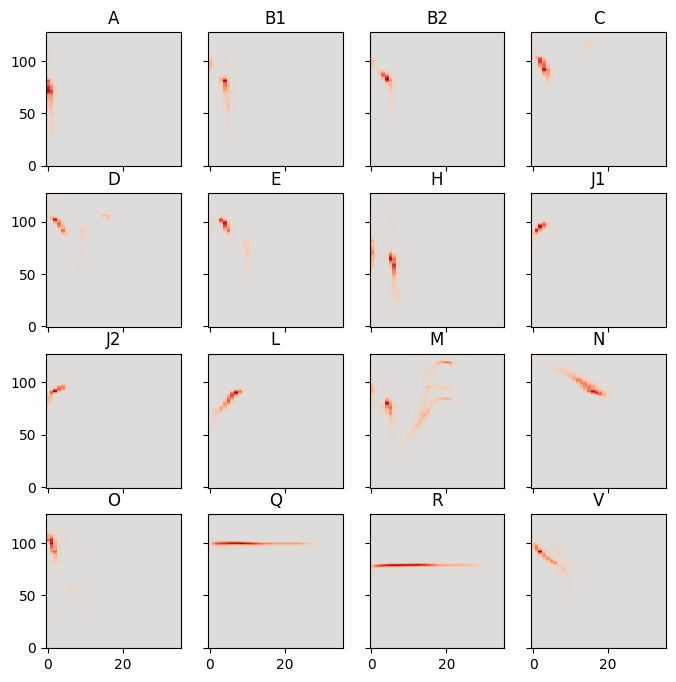

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    im = ax.imshow(
        np.mean(rdf.query("label==@lbl").spec.values, axis=0), 
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="coolwarm",
        norm=mpl.colors.CenteredNorm()
    )
    ax.set_title(lbl)

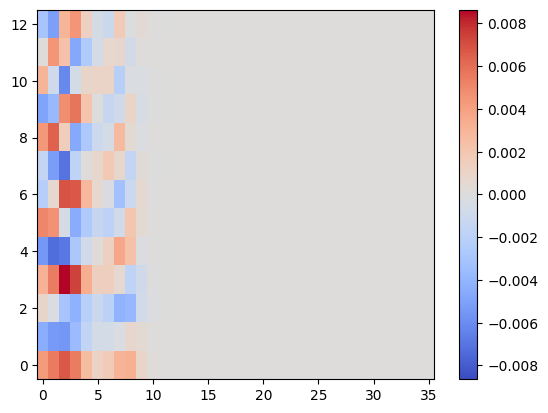

In [61]:
plt.imshow(rdf.spec[15600], aspect="auto", origin="lower", cmap="coolwarm", interpolation="none", norm=mpl.colors.CenteredNorm())
plt.colorbar()

In [62]:
mean_f = np.mean(get_spec(rdf, feat="spec"), axis=(1, 2))
std_f = np.std(get_spec(rdf, feat="spec"), axis=(1, 2))

In [63]:
rdf["n_spec"] = rdf["spec"].apply(lambda x: x / std_f[:, np.newaxis])

(array([2.000000e+00, 3.000000e+00, 5.000000e+00, 4.000000e+00,
        1.700000e+01, 2.300000e+01, 3.800000e+01, 4.100000e+01,
        6.000000e+01, 7.000000e+01, 7.200000e+01, 9.600000e+01,
        1.050000e+02, 1.460000e+02, 1.270000e+02, 1.590000e+02,
        2.060000e+02, 2.130000e+02, 2.750000e+02, 3.720000e+02,
        4.030000e+02, 4.990000e+02, 6.490000e+02, 8.070000e+02,
        1.097000e+03, 1.647000e+03, 3.439000e+03, 7.590000e+03,
        9.953000e+03, 1.288600e+04, 1.622800e+04, 2.133100e+04,
        2.798000e+04, 3.339300e+04, 3.943600e+04, 4.431400e+04,
        5.155200e+04, 6.739700e+04, 7.977000e+04, 9.567000e+04,
        1.186550e+05, 1.577190e+05, 3.157070e+05, 5.448715e+06,
        2.114490e+05, 1.362760e+05, 1.028090e+05, 8.640600e+04,
        7.306300e+04, 6.119000e+04, 5.368600e+04, 4.542600e+04,
        3.713900e+04, 3.117000e+04, 2.470300e+04, 2.033600e+04,
        1.455200e+04, 1.045200e+04, 6.506000e+03, 3.683000e+03,
        2.611000e+03, 1.903000e+03, 1.38

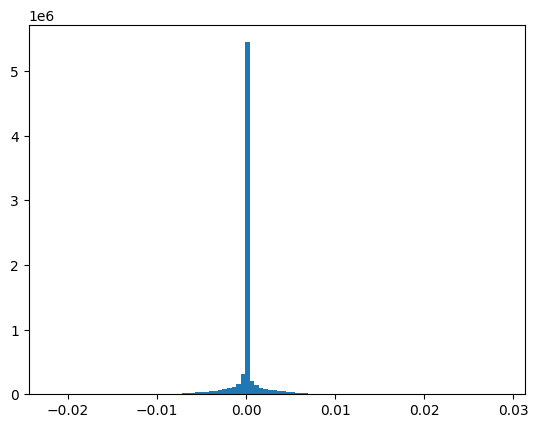

In [72]:
plt.hist(get_spec(rdf, feat="spec").flatten(), bins=100)

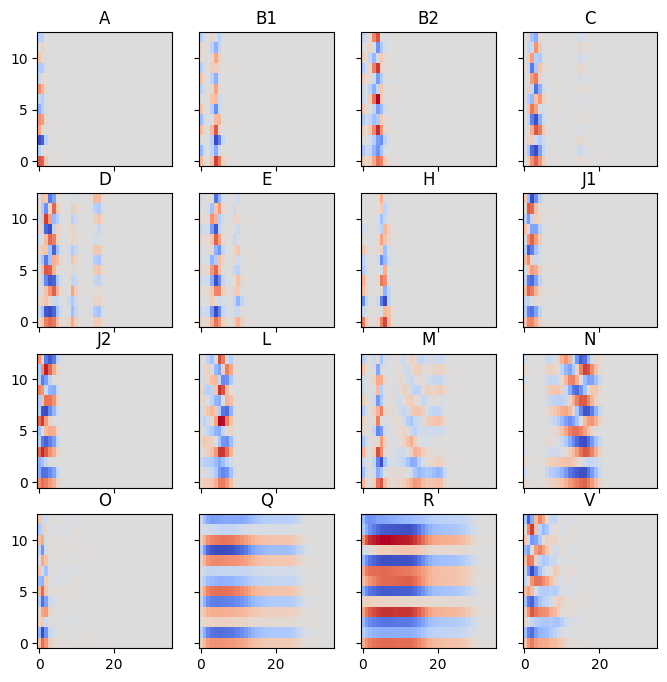

In [64]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    im = ax.imshow(
        np.mean(rdf.query("label==@lbl").n_spec.values, axis=0),
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="coolwarm",
        norm=mpl.colors.CenteredNorm())
    ax.set_title(lbl)

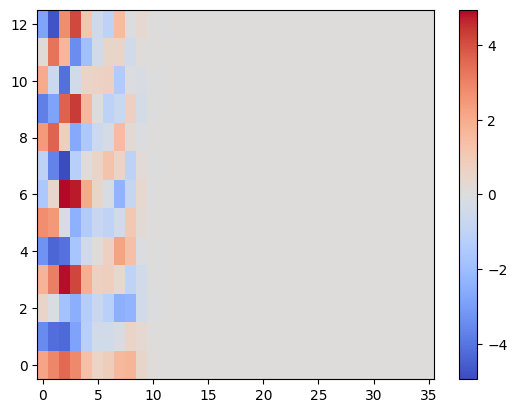

In [65]:
plt.imshow(rdf.n_spec[15600], aspect="auto", origin="lower", cmap="coolwarm", interpolation="none", norm=mpl.colors.CenteredNorm())
plt.colorbar()

In [75]:
get_spec(rdf, feat="spec").min(), get_spec(rdf, feat="spec").max()

(-0.021896575, 0.028751716)

In [82]:
np.quantile(get_spec(rdf, feat="spec"), 0.05), np.quantile(get_spec(rdf, feat="spec"), 0.95)

(-0.002438995218835771, 0.002529301098547873)

In [76]:
get_spec(rdf, feat="n_spec").min(), get_spec(rdf, feat="n_spec").max()

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

(array([3.000000e+00, 3.000000e+00, 3.000000e+00, 9.000000e+00,
        1.600000e+01, 2.300000e+01, 3.300000e+01, 4.000000e+01,
        4.200000e+01, 6.700000e+01, 7.500000e+01, 8.200000e+01,
        1.070000e+02, 1.120000e+02, 1.420000e+02, 1.310000e+02,
        1.540000e+02, 2.150000e+02, 2.120000e+02, 2.940000e+02,
        3.600000e+02, 3.980000e+02, 4.890000e+02, 6.700000e+02,
        9.750000e+02, 1.470000e+03, 2.255000e+03, 3.564000e+03,
        5.368000e+03, 8.328000e+03, 1.299000e+04, 1.819100e+04,
        2.170600e+04, 2.528500e+04, 2.983400e+04, 3.333500e+04,
        3.618200e+04, 4.060700e+04, 4.890900e+04, 5.587400e+04,
        6.304600e+04, 7.165400e+04, 8.279400e+04, 9.962200e+04,
        1.288560e+05, 2.081910e+05, 5.424131e+06, 2.542900e+05,
        1.507360e+05, 1.093390e+05, 9.065100e+04, 7.791400e+04,
        6.523700e+04, 5.682800e+04, 4.823400e+04, 4.192900e+04,
        3.793600e+04, 3.081500e+04, 2.412300e+04, 1.854500e+04,
        1.470100e+04, 1.165000e+04, 7.71

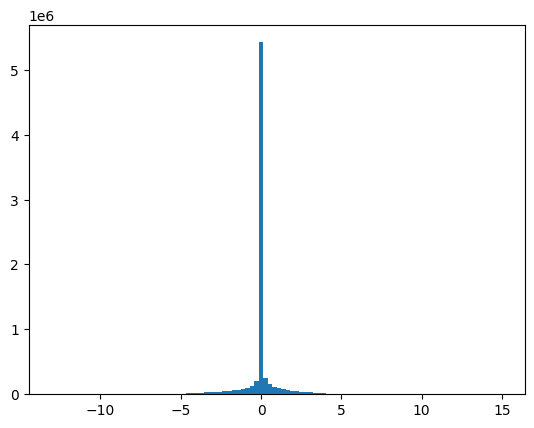

In [73]:
plt.hist(get_spec(rdf, feat="n_spec").flatten(), bins=100)

In [202]:
labels = sorted(rdf.label.unique().tolist())
mean_feats = [np.mean(get_features(rdf.query("label==@l"), feat="spec"), axis=0, keepdims=True) for l in labels]
mean_feats = np.vstack(mean_feats)
mean_feats[0, None].shape

(1, 468)

## Load generated syllables

In [16]:
def preprocess_archives(files, n_per_epoch, max_length, kind="mfcc"):
    @delayed
    def load(f):
        d = np.load(f)
        x = d["x"][:n_per_epoch, :max_length]
        x = lbr.util.normalize(x, axis=1)
        # sos = scipy.signal.butter(5, 500, btype='high', output='sos', fs=sr)
        # x = scipy.signal.sosfiltfilt(sos, x)
        if kind == "mfcc":
            return make_mfcc(x)
        elif kind == "spec":
            return make_spectrogram(x)
        elif kind == "spec2":
            return make_spectrogram2(x)
        elif kind == "mel":
            return make_melspectrogram(x)
        else:
            raise NotImplementedError(kind)
    
    results = Parallel(n_jobs=4, verbose=100)(load(f) for f in files)

    return results

In [24]:
files = list(gen_dir.rglob("version_16/*epoch_989*.npz"))
archives = [np.load(f) for f in files][0]
x = archives["x"]

In [25]:
list(archives.keys())

['x',
 'y',
 'z',
 'version',
 'epoch',
 'step',
 'y_mean',
 'y_max',
 'y_argmax',
 'y_sum',
 'UMAP 1',
 'UMAP 2',
 'hdbscan_y',
 'hdbscan_remap',
 'y_knn_deltas',
 'y_svm_deltas',
 'y_esn_deltas']

In [29]:
files = list(gen_dir.rglob("version_16/*epoch_989*.npz"))

n_per_epoch = -1
archives = [np.load(f) for f in files]
x = preprocess_archives(files, n_per_epoch=n_per_epoch, max_length=max_length, kind="mfcc")
x = np.vstack([x_[np.newaxis] for x_ in x])

specs = preprocess_archives(files, n_per_epoch=n_per_epoch, max_length=max_length, kind="mel")
specs = np.vstack([x_[np.newaxis] for x_ in specs])

data_table = {
    "file": files,
    "version": [int(d["version"]) for d in archives],
    "epoch": [int(d["epoch"]) for d in archives],
    "y": [d["y_argmax"][:n_per_epoch] for d in archives],
    "sr": 16000,
    "z": [d["z"][:n_per_epoch] for d in archives],
    "s": list(x),
    "spec": list(specs),
    "kind": "gen",
    "y_esn_deltas": [d["y_esn_deltas"][:n_per_epoch] for d in archives],
    "y_knn_deltas": [d["y_knn_deltas"][:n_per_epoch] for d in archives],
    "y_svm_deltas": [d["y_svm_deltas"][:n_per_epoch] for d in archives],    
}
# gdf = pd.DataFrame(data_table).explode(["s", "y", "z", "spec"]).sort_values(by=["version", "epoch"]).reset_index(drop=True)
gdf = pd.DataFrame(data_table).explode(["y", "y_esn_deltas", "y_knn_deltas", "y_svm_deltas", "z", "spec"]).sort_values(by=["version", "epoch"]).reset_index(drop=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.5s


In [193]:
mean_g = np.mean(get_spec(gdf, feat="spec"), axis=(1, 2))
std_g = np.std(get_spec(gdf, feat="spec"), axis=(1, 2))

gdf["n_spec"] = gdf["spec"].apply(lambda x: (x - mean_g[:, np.newaxis]) / std_g[:, np.newaxis])

## Inspect n_neighbors

In [115]:
r_features = np.concatenate(np.dstack(rdf.s.values)).T
g_features = np.concatenate(np.dstack(gdf.s.values)).T

path = Path("nn_tests")
path.mkdir(parents=True, exist_ok=True)
for nn in range(10, 110, 10):
    reducer = umap.UMAP(
        n_neighbors=nn,
        min_dist=0.9,
        n_components=2,
        metric="euclidean",
        verbose=True,
    )
    
    r_embeddings = reducer.fit_transform(r_features)
    rdf[["embed_x", "embed_y"]] = r_embeddings

    g_embeddings = reducer.transform(g_features)
    gdf[["embed_x", "embed_y"]] = g_embeddings
    
    plt.figure(figsize=(8, 8))
    g = sns.scatterplot(data=rdf, x="embed_x", y="embed_y", hue="label", s=5, ec=None, alpha=1, palette="tab20")
    g.legend(markerscale=5)
    g = sns.scatterplot(data=gdf, x="embed_x", y="embed_y", s=5, ec=None, alpha=1, marker="+", color="black")
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    sns.despine()
    plt.savefig(path / f"nn-{nn}.pdf", bbox_inches="tight")
    plt.close()

AttributeError: 'DataFrame' object has no attribute 's'

## Classifier from sound

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

train_idxs, test_idxs = train_test_split(np.arange(len(rdf)), test_size=0.1, stratify=rdf["label"], random_state=0)

rdf["split"] = "train"
rdf.loc[test_idxs, "split"] = "test"

In [195]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

tic = time.time()
y_pred = knn.fit(
    get_features(rdf.query("split=='train'"), feat="spec"), 
    rdf.query("split=='train'")["label"]
).predict(get_features(rdf.query("split=='test'"), feat="spec"))
toc = time.time()
print("Elapsed: ", toc - tic)

acc = accuracy_score(rdf.query("split=='test'")["label"], y_pred)
f1 = f1_score(rdf.query("split=='test'")["label"], y_pred, average="micro")
print(acc, f1)

rdf["knn_y"] = knn.predict(get_features(rdf, feat="spec"))
gdf["knn_y"] = knn.predict(get_features(gdf, feat="spec"))

Elapsed:  0.35686469078063965
0.97125 0.97125


In [76]:
from sklearn.svm import SVC

svm = SVC(C=0.1)

tic = time.time()
y_pred = svm.fit(
    get_features(rdf.query("split=='train'"), feat="spec"), 
    rdf.query("split=='train'")["label"]
).predict(get_features(rdf.query("split=='test'"), feat="spec"))
toc = time.time()
print("Elapsed: ", toc - tic)

acc = accuracy_score(rdf.query("split=='test'")["label"], y_pred)
f1 = f1_score(rdf.query("split=='test'")["label"], y_pred, average="micro")
print(acc, f1)

rdf["svm_y"] = svm.predict(get_features(rdf, feat="spec"))
gdf["svm_y"] = svm.predict(get_features(gdf, feat="spec"))

Elapsed:  405.75008249282837
0.979375 0.979375


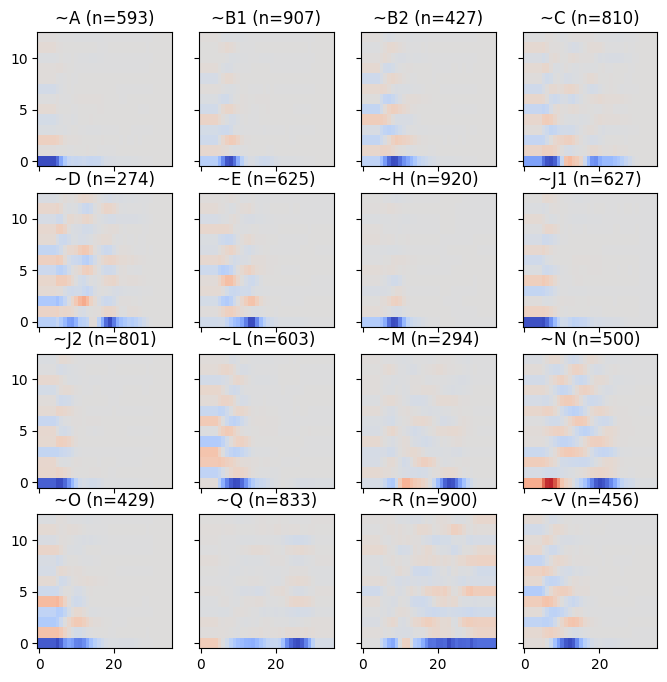

In [196]:
predictor="knn_y"

labels = sorted(gdf[predictor].unique())
if "X" in labels:
    labels.remove("X")

n = len(labels)
n_cols = 4
n_rows = n // 4 + int(n % 4 > 0)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    q = gdf.query(f"{predictor}==@lbl")
    ax.imshow(
        np.mean(q.spec.values, axis=0),
        # q.spec.values[2],
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="coolwarm",
        norm=mpl.colors.CenteredNorm()
    )
    ax.set_title(f"~{lbl} (n={len(q)})")

In [36]:
for i, lbl in enumerate(labels):
    q = gdf.query(f"{predictor}==@lbl")
    s = get_spec(q, feat="spec")

## Embed

In [31]:
r_features = np.concatenate(np.dstack(rdf.spec.values)).T
g_features = np.concatenate(np.dstack(gdf.spec.values)).T

reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.9,
    n_components=2,
    metric="euclidean", 
    verbose=True,
)

r_embeddings = reducer.fit_transform(r_features)
rdf[["embed_x", "embed_y"]] = r_embeddings

g_embeddings = reducer.transform(g_features)
gdf[["embed_x", "embed_y"]] = g_embeddings

UMAP(min_dist=0.9, n_neighbors=100, verbose=True)
Fri Apr 12 15:37:59 2024 Construct fuzzy simplicial set
Fri Apr 12 15:37:59 2024 Finding Nearest Neighbors
Fri Apr 12 15:37:59 2024 Building RP forest with 11 trees
Fri Apr 12 15:38:00 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Apr 12 15:38:40 2024 Finished Nearest Neighbor Search
Fri Apr 12 15:38:41 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Apr 12 15:38:50 2024 Finished embedding
Fri Apr 12 15:38:51 2024 Worst tree score: 0.99468750
Fri Apr 12 15:38:51 2024 Mean tree score: 0.99555682
Fri Apr 12 15:38:51 2024 Best tree score: 0.99662500
Fri Apr 12 15:38:52 2024 Forward diversification reduced edges from 1600000 to 122871
Fri Apr 12 15:38:52 2024 Reverse diversification reduced edges from 122871 to 122871
Fri Apr 12 15:38:52 2024 Degree pruning reduced edges from 145864 to 145864
Fri Apr 12 15:38:52 2024 Resorting data and graph based on tree order
Fri Apr 12 15:38:52 2024 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


## HDBSCAN clustering

In [65]:
from sklearn.cluster import HDBSCAN

mdf = pd.concat([rdf, gdf]).reset_index(drop=True)

clusterer = HDBSCAN(min_cluster_size=250, min_samples=250, n_jobs=-1, cluster_selection_method="eom")
auto_labels = clusterer.fit_predict(mdf[["embed_x", "embed_y"]])

rdf["hdbscan_y"] = auto_labels[:len(rdf)]
gdf["hdbscan_y"] = auto_labels[len(rdf):]

In [66]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=30, n_init=20)
auto_reals = gmm.fit_predict(rdf[["embed_x", "embed_y"]])
auto_gens = gmm.predict(gdf[["embed_x", "embed_y"]])

rdf["gmm_y"] = auto_reals
gdf["gmm_y"] = auto_gens

In [67]:
from sklearn.cluster import BisectingKMeans

bsect = BisectingKMeans(n_clusters=20)
auto_reals = bsect.fit_predict(rdf[["embed_x", "embed_y"]])
auto_gens = bsect.predict(gdf[["embed_x", "embed_y"]])

rdf["bsect_kmeans_y"] = auto_reals
gdf["bsect_kmeans_y"] = auto_gens

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)
auto_reals = knn.fit(rdf[["embed_x", "embed_y"]], rdf["label"]).predict(rdf[["embed_x", "embed_y"]])
auto_gens = knn.predict(gdf[["embed_x", "embed_y"]])
auto_proba = knn.predict_proba(gdf[["embed_x", "embed_y"]])

auto_gens[gdf["hdbscan_y"].values == -1] = 'X'

rdf["knn_umap"] = auto_reals
gdf["knn_umap"] = auto_gens

In [69]:
from sklearn.svm import SVC

svm = SVC()
auto_reals = svm.fit(rdf[["embed_x", "embed_y"]], rdf["label"]).predict(rdf[["embed_x", "embed_y"]])
auto_gens = svm.predict(gdf[["embed_x", "embed_y"]])

rdf["svm_umap"] = auto_reals
gdf["svm_umap"] = auto_gens

In [70]:
from scipy.spatial.distance import cdist

remb = rdf[["embed_x", "embed_y"]].values
gemb = gdf[["embed_x", "embed_y"]].values

l = rdf.iloc[np.argmin(cdist(gemb, remb), axis=1)]["label"]

rdf["hdbscan_remap"] = rdf["y"]

gdf["hdbscan_remap"] = l.values
gdf.loc[gdf.query("hdbscan_y==-1").index, "hdbscan_remap"] = "X"

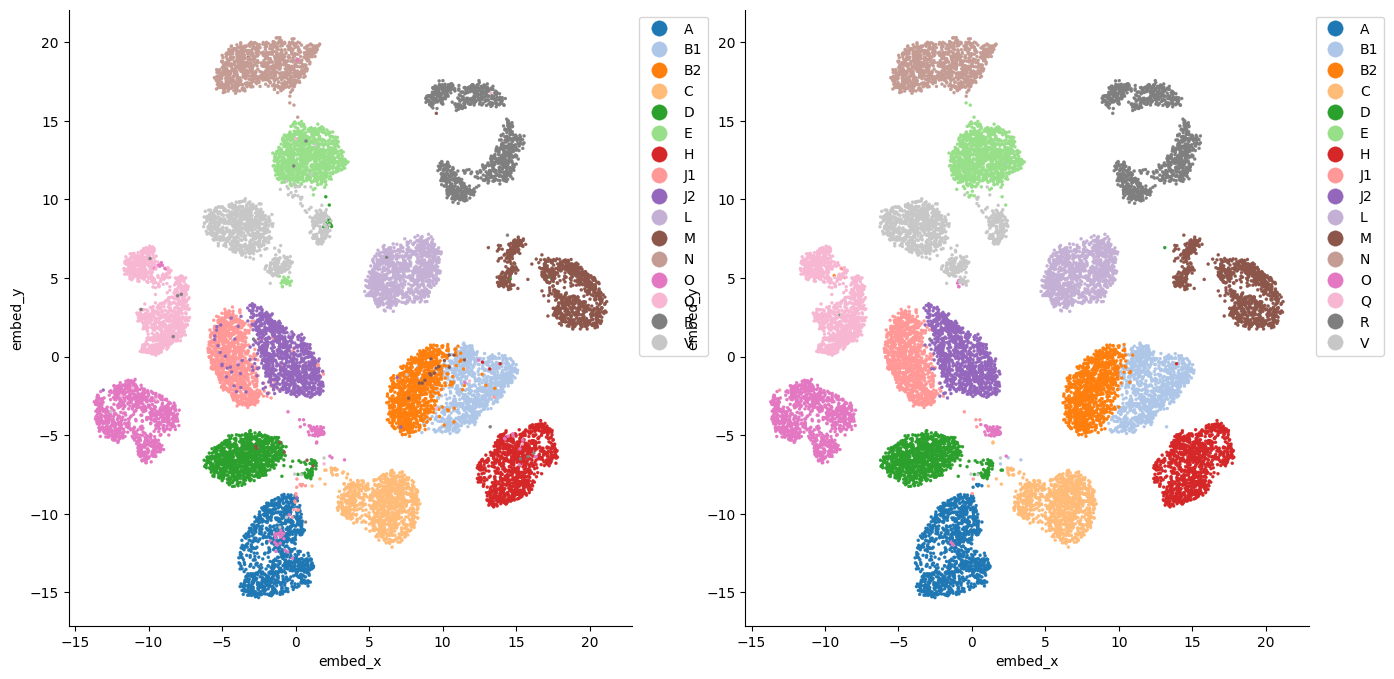

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

g1 = sns.scatterplot(data=rdf, x="embed_x", y="embed_y", hue="label", s=5, ec=None, alpha=1, palette=colors, ax=axs[0])
g1.legend(markerscale=5)

g2 = sns.scatterplot(data=rdf.sort_values(by=["knn_y"]), x="embed_x", y="embed_y", hue="knn_y", s=5, ec=None, alpha=1, palette=colors, ax=axs[1])
g2.legend(markerscale=5)

sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

In [22]:
gdf.columns

Index(['file', 'version', 'epoch', 'y', 'sr', 'z', 's', 'spec', 'kind',
       'embed_x', 'embed_y'],
      dtype='object')

ValueError: The palette dictionary is missing keys: {'EARLY_30', 'EARLY_15', 'WN', 'EARLY_45'}

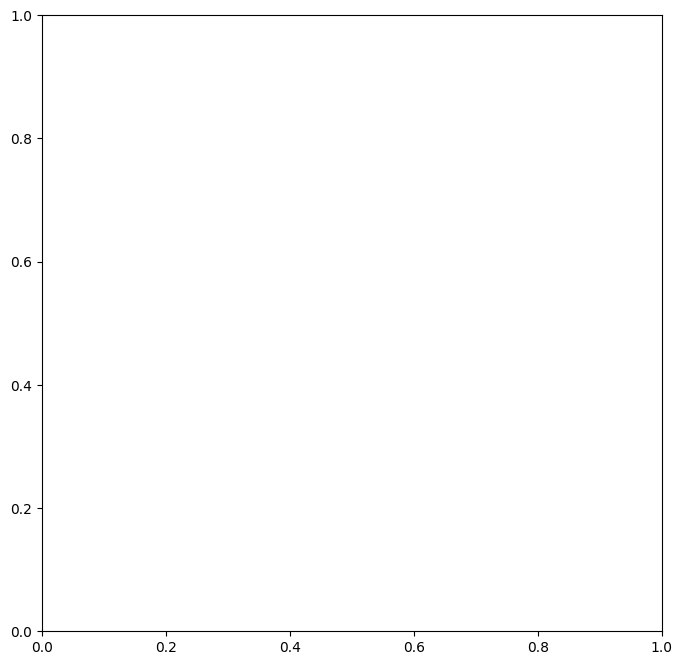

In [32]:
predictor = "y_esn_deltas"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

g = sns.scatterplot(
    data=gdf.sort_values(by=predictor),
    x="embed_x",
    y="embed_y",
    hue=predictor,
    s=5,
    alpha=0.5,
    ec=None,
    linewidths=2,
    palette=colors,
    ax=ax,
    zorder=1,
)
_ = sns.kdeplot(
    data=rdf,
    x="embed_x",
    y="embed_y",
    hue="label",
    palette=colors,
    alpha=0.5,
    levels=5,
    zorder=0,
    legend=False,
    ax=ax,
)

labels = rdf.label.unique()
for i, lbl in enumerate(labels):
    df_l = rdf.query("label==@lbl")
    top = df_l["embed_y"].median() + 1
    mean = df_l["embed_x"].median() - 4
    ax.text(mean, top, lbl, c=colors[lbl], size=12, weight="bold", zorder=2)

g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

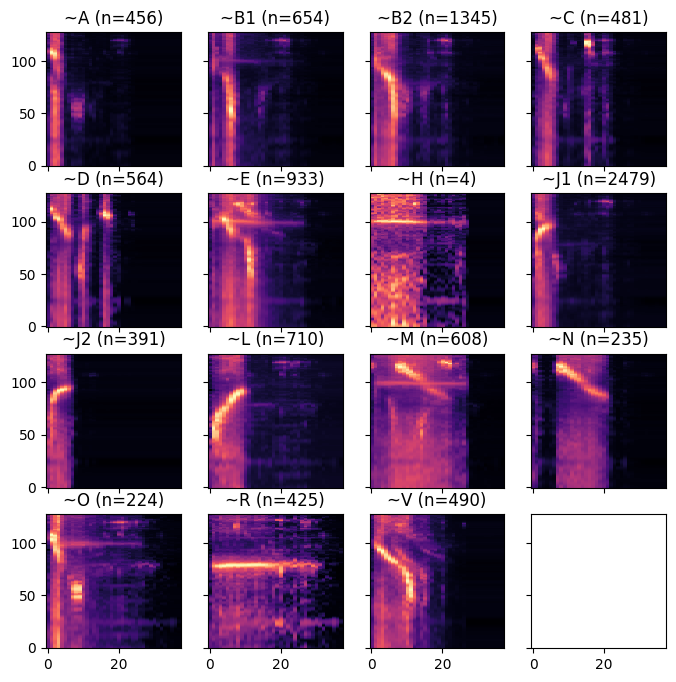

In [73]:
labels = sorted(gdf[predictor].unique())
if "X" in labels:
    labels.remove("X")

n = len(labels)
n_cols = 4
n_rows = n // 4 + int(n % 4 > 0)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    q = gdf.query(f"{predictor}==@lbl")
    ax.imshow(
        np.log(np.mean(np.exp(np.dstack(q.spec.values)) - 1, axis=-1) + 1),
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="magma",
    )
    ax.set_title(f"~{lbl} (n={len(q)})")

# AlignedUMAP
https://umap-learn.readthedocs.io/en/latest/aligned_umap_politics_demo.html

## Define slices

In [29]:
def concat_specs(df1, df2):
    return np.concatenate(np.dstack(pd.concat([df1, df2]).s.values)).T

In [14]:
epochs = sorted(gdf.epoch.unique().tolist())[::-1]
steps = [concat_specs(rdf, gdf.query("epoch==@e")) for e in epochs]
# steps = [np.concatenate(np.dstack(gdf.query("epoch==@e").s.values)).T for e in epochs]

In [15]:
relations = [{i: i for i in range(len(steps))} for i in range(len(steps) - 1)]

In [ ]:
reducer = umap.AlignedUMAP(
    n_neighbors=100,
    min_dist=0.9,
    n_components=2,
    metric="euclidean",
    verbose=True,
    low_memory=True,
)

reducer.fit(steps, relations=relations)

UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:29:57 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:01 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:02 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:02 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:04 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:04 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:08 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:08 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:08 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:11 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:11 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:15 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:15 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:15 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:18 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:18 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:22 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:22 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:22 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:25 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:25 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:29 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:29 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:29 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:32 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:32 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:36 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:36 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:36 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:39 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:39 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:43 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:43 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:43 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:45 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:45 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:50 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:50 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:50 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:52 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:52 2024 Construct fuzzy simplicial set
Fri Mar  1 16:30:56 2024 Finding Nearest Neighbors
Fri Mar  1 16:30:56 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:30:56 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:30:59 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:30:59 2024 Construct fuzzy simplicial set
Fri Mar  1 16:31:03 2024 Finding Nearest Neighbors
Fri Mar  1 16:31:03 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:31:03 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:31:06 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:31:06 2024 Construct fuzzy simplicial set
Fri Mar  1 16:31:10 2024 Finding Nearest Neighbors
Fri Mar  1 16:31:10 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:31:10 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:31:13 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:31:13 2024 Construct fuzzy simplicial set
Fri Mar  1 16:31:16 2024 Finding Nearest Neighbors
Fri Mar  1 16:31:16 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:31:17 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:31:19 2024 Finished embedding
UMAP(min_dist=0.9, n_epochs=200, n_neighbors=100, verbose=True)
Fri Mar  1 16:31:19 2024 Construct fuzzy simplicial set
Fri Mar  1 16:31:23 2024 Finding Nearest Neighbors
Fri Mar  1 16:31:23 2024 Finished Nearest Neighbor Search
Fri Mar  1 16:31:23 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar  1 16:31:26 2024 Finished embedding


# ParametricUMAP

In [30]:
features = concat_specs(rdf, gdf)
    
real_reducer = umap.ParametricUMAP(
    n_neighbors=100,
    min_dist=0.9,
    n_components=2,
    metric="euclidean",
    verbose=True,
)

tic = time.time()
embeddings = real_reducer.fit_transform(features)
toc = time.time()

print(f"Elapsed: {toc - tic} s")

/home/nathan/Code/pmseq/venv/lib/python3.11/site-packages/umap/parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


ParametricUMAP(optimizer=<keras.src.optimizers.adam.Adam object at 0x7f99386fe5d0>)
Fri Mar  1 17:58:31 2024 Construct fuzzy simplicial set
Fri Mar  1 17:58:31 2024 Finding Nearest Neighbors
Fri Mar  1 17:58:31 2024 Building RP forest with 14 trees
Fri Mar  1 17:58:31 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Fri Mar  1 17:58:40 2024 Finished Nearest Neighbor Search
Fri Mar  1 17:58:41 2024 Construct embedding


2024-03-01 17:58:52.158506: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522030704 exceeds 10% of free system memory.
2024-03-01 17:58:52.499181: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522030704 exceeds 10% of free system memory.
2024-03-01 17:58:52.709493: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522030704 exceeds 10% of free system memory.
2024-03-01 17:58:52.887911: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522030704 exceeds 10% of free system memory.
2024-03-01 17:58:53.712416: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522030704 exceeds 10% of free system memory.


Epoch 1/10
6525/6525 [==============================] - 23s 3ms/step - loss: 0.1446
Epoch 2/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1425
Epoch 3/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1421
Epoch 4/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1418
Epoch 5/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1416
Epoch 6/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1415
Epoch 7/10
6525/6525 [==============================] - 22s 3ms/step - loss: 0.1414
Epoch 8/10
6525/6525 [==============================] - 21s 3ms/step - loss: 0.1414
Epoch 9/10
6525/6525 [==============================] - 21s 3ms/step - loss: 0.1414
Epoch 10/10
907/907 [==============================] - 1s 869us/step
Fri Mar  1 18:02:33 2024 Finished embedding
Elapsed: 241.93292140960693 s


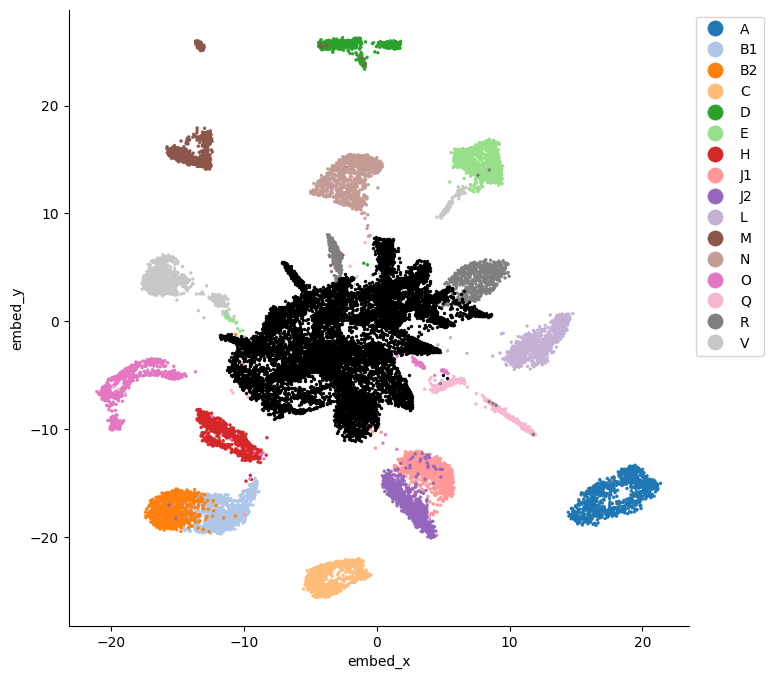

In [36]:
rdf[["embed_x", "embed_y"]] = embeddings[:len(rdf), :]
gdf[["embed_x", "embed_y"]] = embeddings[len(rdf):, :]
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data=rdf, x="embed_x", y="embed_y", hue="label", s=5, ec=None, alpha=1, palette="tab20")
g = sns.scatterplot(data=gdf, x="embed_x", y="embed_y", s=5, ec=None, alpha=1, color="black")
g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

# Old stuff

In [4]:
files = list(data_dir.rglob("**/*.wav"))

sr = 16000
max_length = round(sr * 0.3) 

data_table = {
    "file": files,
    "label": [f.parent.name for f in files],
    "x": [lbr.load(f, sr=None)[0][:max_length] for f in track(files, "Loading")],
    "sr": 16000,
    "kind": "real",
}

Output()

In [5]:
df = pd.DataFrame(data_table).sort_values(by=["label", "file"])
df.head()

,file,label,x,sr,kind
0,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0005187988, -0.00015258789, 0.00018310547,...",16000,real
1,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0009460449, -0.0002746582, -6.1035156e-05,...",16000,real
2,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0035705566, 6.1035156e-05, 0.0016479492, 0...",16000,real
3,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0008544922, 0.0, 0.00021362305, 0.00042724...",16000,real
4,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.00064086914, -0.00015258789, 0.00015258789...",16000,real


In [102]:
g = np.vstack(gdf["x"].values)[:, :max_length]

In [103]:
x = np.vstack(df["x"].values)

In [104]:
xn = (x - x.mean()) / x.std()

In [5]:
labels = df.label.unique()
labels

array(['A', 'B1', 'B2', 'C', 'D', 'E', 'H', 'J1', 'J2', 'L', 'M', 'N',
       'O', 'Q', 'R', 'V'], dtype=object)

In [6]:
def make_spectrogram(x):
    s = lbr.stft(x, hop_length=128, win_length=256, n_fft=1024)
    return lbr.power_to_db(np.abs(s)**2)

df["spec"] = list(make_spectrogram(np.vstack(df.x.values)))

In [7]:
df

,file,label,x,sr,kind,spec
0,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0005187988, -0.00015258789, 0.00018310547,...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
1,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0009460449, -0.0002746582, -6.1035156e-05,...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
2,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0035705566, 6.1035156e-05, 0.0016479492, 0...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
3,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.0008544922, 0.0, 0.00021362305, 0.00042724...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
4,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,"[-0.00064086914, -0.00015258789, 0.00015258789...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
...,...,...,...,...,...,...
15995,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,V,"[-0.0007324219, 0.00012207031, 0.00030517578, ...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
15996,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,V,"[-0.0007019043, -0.00015258789, 0.00033569336,...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
15997,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,V,"[0.00036621094, 0.0, -0.00021362305, -0.000274...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."
15998,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,V,"[-0.00030517578, 0.00021362305, -3.0517578e-05...",16000,real,"[[-44.29562, -44.29562, -44.29562, -44.29562, ..."


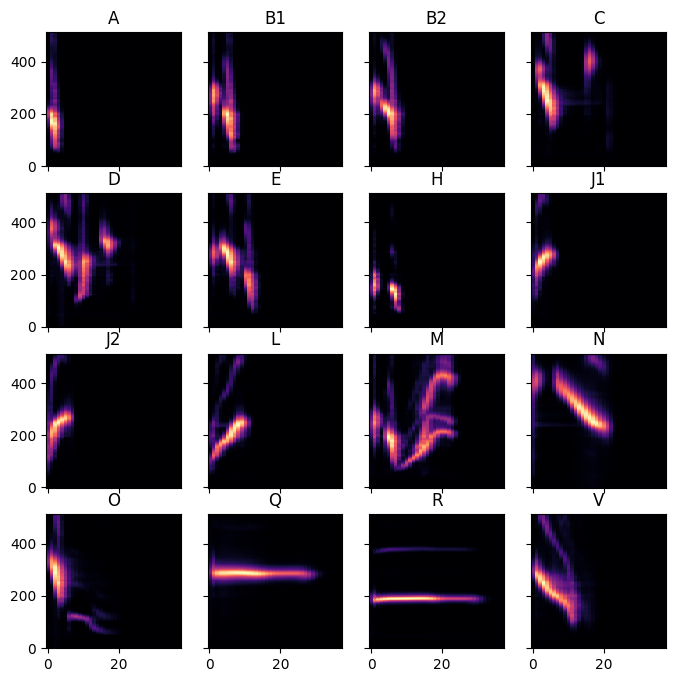

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    ax.imshow(np.mean(df.query("label==@lbl").spec.values, axis=0), aspect="auto", origin="lower", interpolation="none", cmap="magma")
    ax.set_title(lbl)

In [13]:
import time
import pickle

if Path("./umap-reducer.pkl").is_file():
    with open("./umap-reducer.pkl", "rb") as fp:
        reducer = pickle.load(fp)
else:
    features = np.concatenate(np.dstack(df.spec.values)).T
    
    reducer = umap.UMAP(
        n_neighbors=100,
        min_dist=0.9,
        n_components=2,
        metric="euclidean",
        verbose=True,
        random_state=42,
    )
    
    tic = time.time()
    reducer.fit(features)
    toc = time.time()
    
    print(f"Elapsed: {toc - tic} s")
    
    with open("./umap-reducer.pkl", "wb+") as fp:
        pickle.dump(reducer, fp)

Tue Feb 27 15:54:36 2024 Building and compiling search function


In [90]:
import dill

with open("/run/media/nathan/Nathan4T/Nathan-canarygan/umap-reducer.pkl", "wb+") as fp:
    dill.dump(reducer, fp)

In [15]:
embeddings = reducer.transform(features)

In [16]:
df[["embed_x", "embed_y"]] = embeddings

In [17]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=500, min_samples=250, n_jobs=-1, cluster_selection_method="eom")
auto_labels = clusterer.fit_predict(embeddings)

In [18]:
df["auto_labels"] = auto_labels

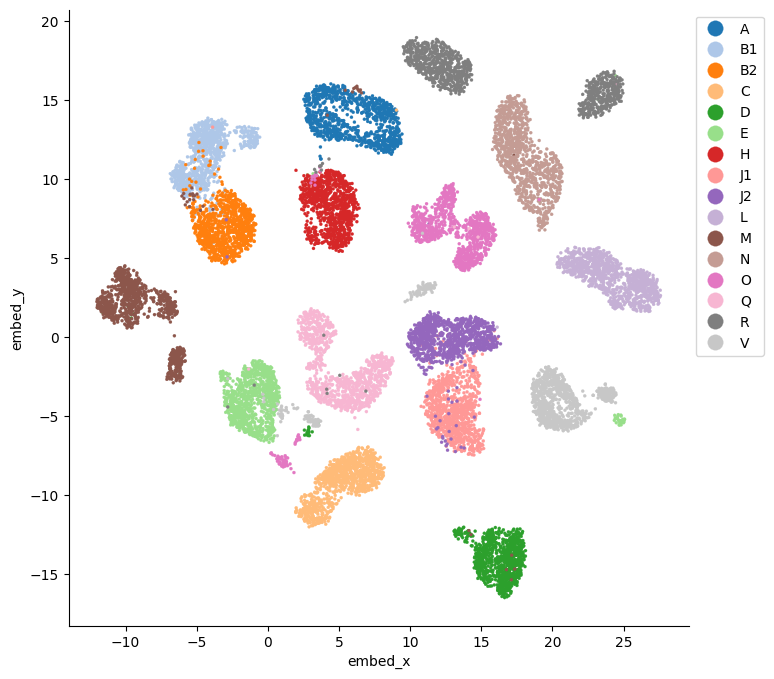

In [19]:
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data=df, x="embed_x", y="embed_y", hue="label", s=5, ec=None, alpha=1, palette="tab20")
g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

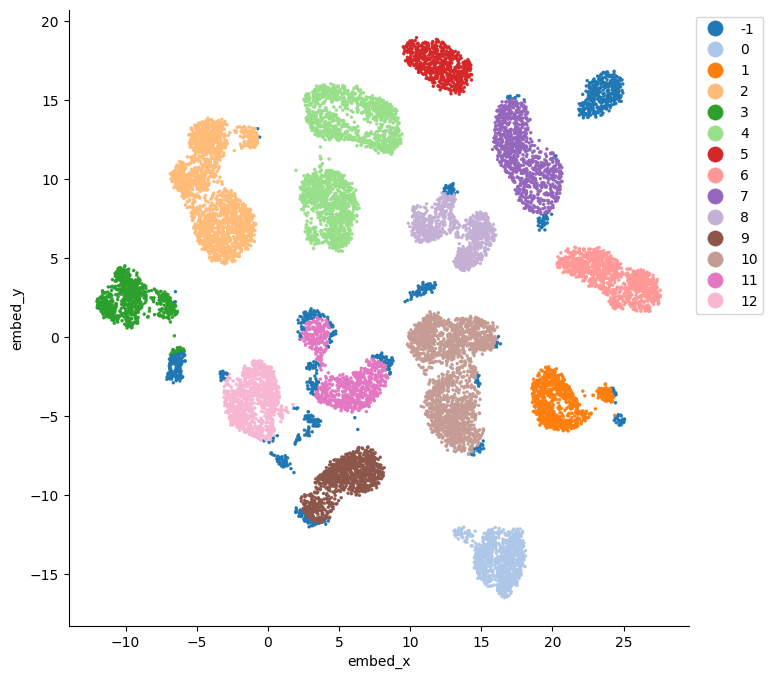

In [20]:
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data=df, x="embed_x", y="embed_y", hue="auto_labels", s=5, ec=None, alpha=1, palette="tab20")
g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

In [59]:
files = list(gen_dir.rglob("version_16/*epoch_989*.npz"))

epoch_selection = [989]
version_selection = [16] 

archives = [np.load(f) for f in files]

data_table = {
    "file": files,
    "version": [int(d["version"]) for d in archives],
    "epoch": [int(d["epoch"]) for d in archives],
    "y": [d["y_argmax"] for d in archives],
    "sr": 16000,
    "z": [d["z"] for d in archives],
    "kind": "gen",
    "x": [d["x"] for d in archives],
}

gdf = pd.DataFrame(data_table)\
        .sort_values(by=["version", "epoch"])\
        .query("epoch in @epoch_selection and version in @version_selection")

In [51]:
gdf["label"] = gdf.epoch.replace(
    {
        14: "EARLY_15",
        29: "EARLY_30",
        44: "EARLY_45",
        614: "MID_614",
        859: "LATE_859",
        989: "LATE_989",
    }
)

In [52]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 8 to 8
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     1 non-null      object
 1   version  1 non-null      int64 
 2   epoch    1 non-null      int64 
 3   y        1 non-null      object
 4   sr       1 non-null      int64 
 5   z        1 non-null      object
 6   kind     1 non-null      object
 7   label    1 non-null      object
dtypes: int64(3), object(5)
memory usage: 72.0+ bytes


In [60]:
gdf = gdf.explode(["x", "y", "z"]).reset_index(drop=True)

In [25]:
from itertools import product

gdf["embed_x"] = 0.0
gdf["embed_y"] = 0.0

g_embeddings = np.zeros((len(gdf), 2))
for version, epoch in track(list(product(version_selection, epoch_selection))):
    sel = gdf.query("version==@version and epoch==@epoch")
    idxs = sel.index
    d = np.load(sel.file.unique()[0])
    x = d["x"][:, :max_length]
    x = make_spectrogram(x)
    g_embeddings[idxs] = reducer.transform(np.concatenate(x.T).T)

gdf[["embed_x", "embed_y"]] = g_embeddings

Output()

SystemError: CPUDispatcher(<function NNDescent._init_search_function.<locals>.search_closure at 0x7fd8255e4180>) returned a result with an exception set

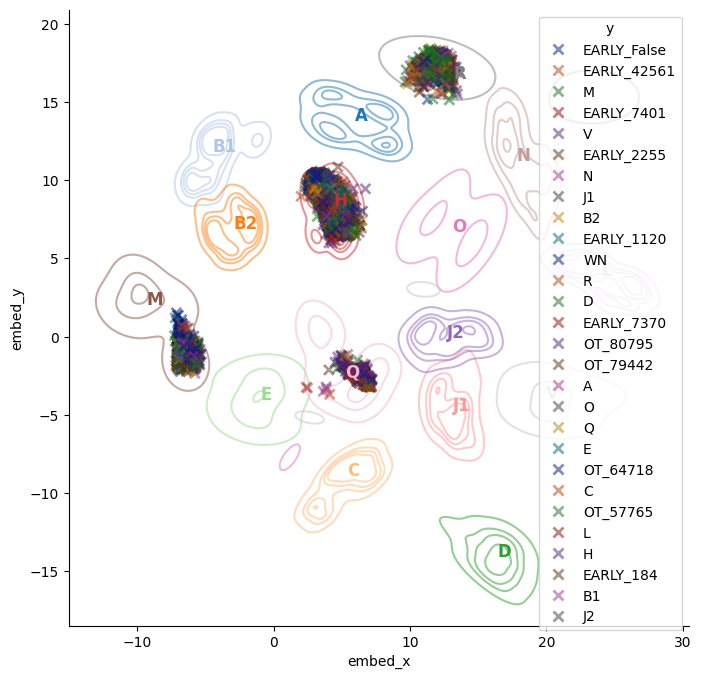

In [253]:
fig, ax = plt.subplots(figsize=(8, 8))
#g = sns.scatterplot(data=df, x="embed_x", y="embed_y", hue="label", s=50, alpha=0.5, palette="tab20")

g = sns.scatterplot(data=gdf, x="embed_x", y="embed_y", hue="y", s=50, alpha=0.5, marker="x", linewidths=2, palette="dark", ax=ax)
for i, lbl in enumerate(labels):
    df_l = df.query("label==@lbl")
    top = df_l["embed_y"].median()
    mean = df_l["embed_x"].median()
    ax.text(mean, top, lbl, c=sns.color_palette("tab20")[i], size=12, weight="bold")
g = sns.kdeplot(data=df, x="embed_x", y="embed_y", hue="label", palette="tab20", alpha=0.5, levels=5, zorder=0, ax=ax, legend=False)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
sns.despine()

In [26]:
d = np.load(gdf.file.unique()[0])
x = d["x"][:, :max_length]
x = list(make_spectrogram(x))
gdf["spec"] = x

In [ ]:
q = gdf.query("embed_x >= 10 and embed_x <= 20 and embed_y >= 13 and embed_y <= 20")
print(len(q))
plt.imshow(np.mean(q.spec.values, axis=0), aspect="auto", origin="lower", interpolation="none", cmap="magma")

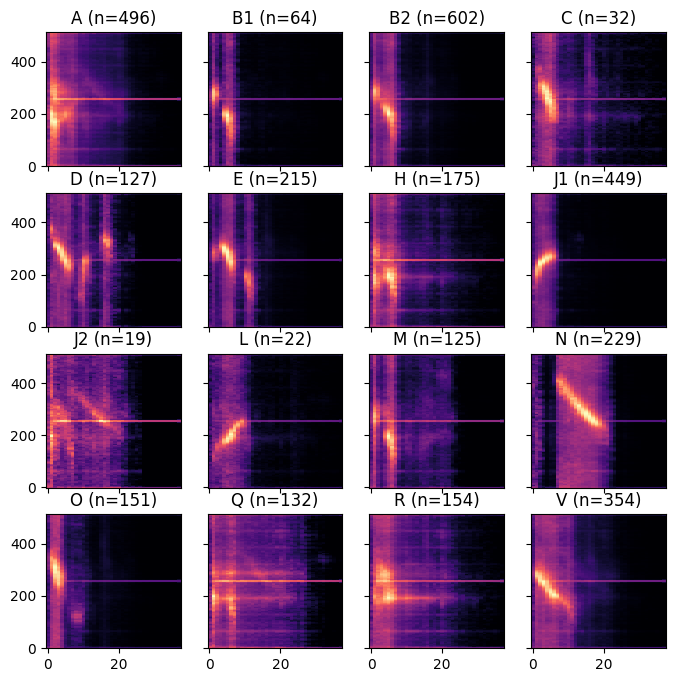

In [28]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    q = gdf.query("y==@lbl")
    if len(q) == 0:
        continue
    ax.imshow(np.mean(q.spec.values, axis=0), aspect="auto", origin="lower", interpolation="none", cmap="magma")
    ax.set_title(f"{lbl} (n={len(q)})")

In [29]:
mixed_features = np.concatenate([np.concatenate(np.dstack(df.spec.values)).T, np.concatenate(np.dstack(gdf.spec.values)).T])

# mixed_reducer = umap.UMAP(
#     n_neighbors=100,
#     min_dist=0.9,
#     n_components=2,
#     metric="euclidean",
#     verbose=True,
#     random_state=42,
# )

# tic = time.time()
# mixed_reducer.fit(mixed_features)
# toc = time.time()

In [30]:
mixed_df = pd.concat([df, gdf])
# mixed_df[["embed_x", "embed_y"]] = mixed_reducer.transform(mixed_features)
mixed_df[["embed_x", "embed_y"]] = reducer.transform(mixed_features)

Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


In [31]:
mixed_df["y"] = pd.concat([df.label, gdf.y])
mixed_df["y"] = mixed_df["y"].replace({k: "X" for k in gdf.y.unique() if "EARLY" in k or "OT" in k or "WN" in k})

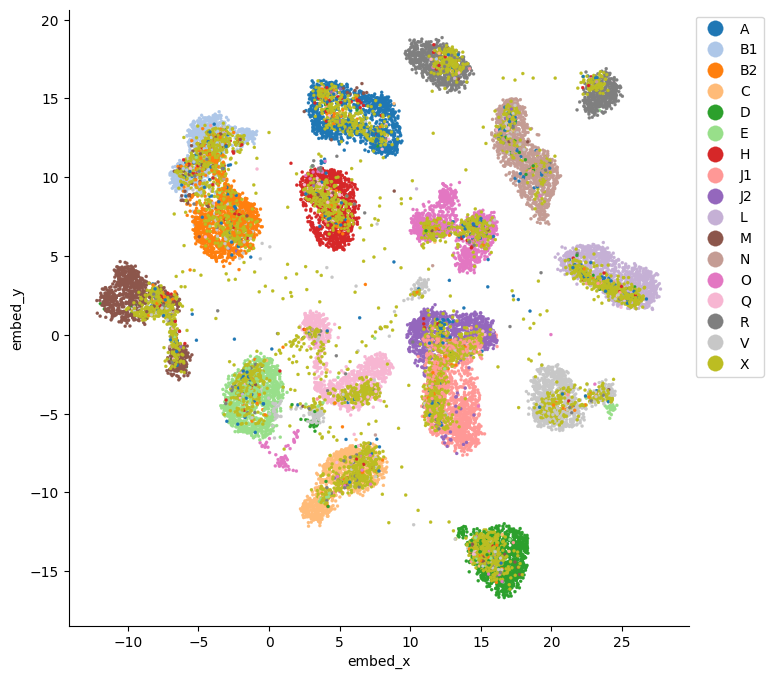

In [32]:
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data=mixed_df, x="embed_x", y="embed_y", hue="y", s=5, ec=None, alpha=1, palette="tab20")
g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

In [60]:
mixed_df["hdbscan_y"] = -1
mixed_df = mixed_df.reset_index(drop=True)

In [61]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=500, min_samples=250, n_jobs=-1, cluster_selection_method="eom")
auto_labels = clusterer.fit_predict(mixed_df[["embed_x", "embed_y"]])
mixed_df["hdbscan_y"] = auto_labels

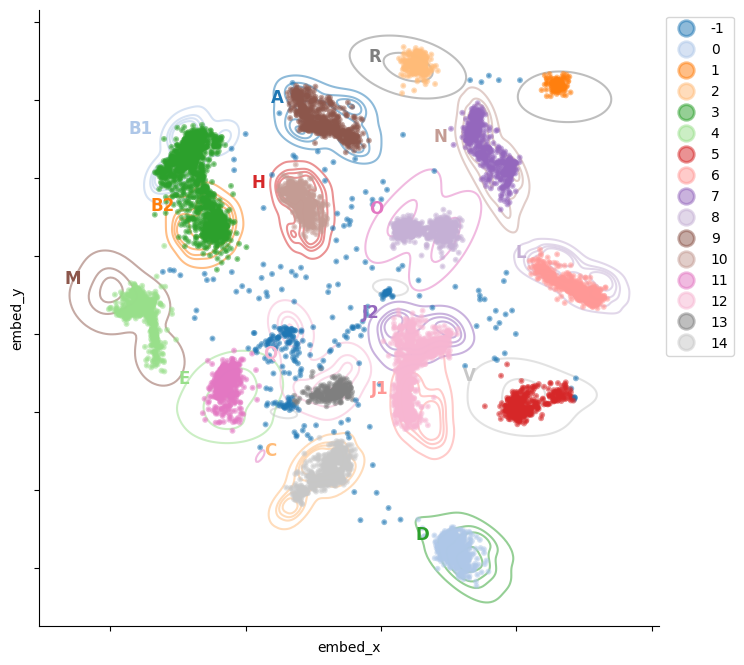

In [62]:
real_df = mixed_df.query("kind=='real'")
gen_df = mixed_df.query("kind=='gen'")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

g = sns.scatterplot(
    data=gen_df,
    x="embed_x",
    y="embed_y",
    hue="hdbscan_y",
    s=5,
    alpha=0.5,
    ec=None,
    linewidths=2,
    palette="tab20",
    ax=ax,
    zorder=1,
)
_ = sns.kdeplot(
    data=real_df,
    x="embed_x",
    y="embed_y",
    hue="y",
    palette="tab20",
    alpha=0.5,
    levels=5,
    zorder=0,
    legend=False,
    ax=ax,
)

labels = real_df.label.unique()
for i, lbl in enumerate(labels):
    df_l = real_df.query("label==@lbl")
    top = df_l["embed_y"].median() + 1
    mean = df_l["embed_x"].median() - 4
    ax.text(mean, top, lbl, c=sns.color_palette("tab20")[i], size=12, weight="bold", zorder=2)

g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [84]:
from scipy.spatial.distance import cdist

real_emb = real_df[["embed_x", "embed_y"]].values
gen_emb = gen_df[["embed_x", "embed_y"]].values

l = real_df.iloc[np.argmin(cdist(gen_emb, real_emb), axis=1)]["label"]

mixed_df["hdbscan_remap"] = mixed_df["y"]
mixed_df.loc[gen_df.index, "hdbscan_remap"] = l.values
mixed_df.loc[gen_df.query("hdbscan_y==-1").index, "hdbscan_remap"] = "X"

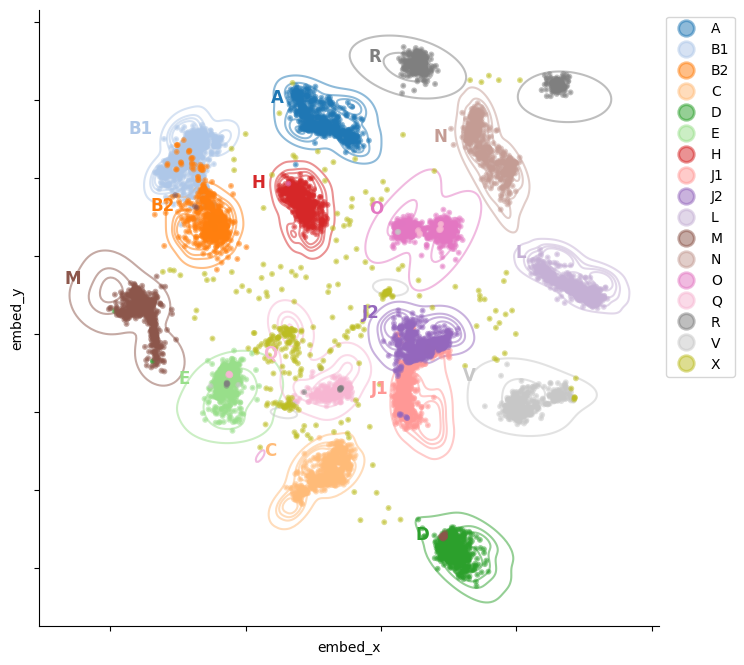

In [85]:
real_df = mixed_df.query("kind=='real'")
gen_df = mixed_df.query("kind=='gen'")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

g = sns.scatterplot(
    data=gen_df.sort_values(by="hdbscan_remap"),
    x="embed_x",
    y="embed_y",
    hue="hdbscan_remap",
    s=5,
    alpha=0.5,
    ec=None,
    linewidths=2,
    palette="tab20",
    ax=ax,
    zorder=1,
)
_ = sns.kdeplot(
    data=real_df,
    x="embed_x",
    y="embed_y",
    hue="y",
    palette="tab20",
    alpha=0.5,
    levels=5,
    zorder=0,
    legend=False,
    ax=ax,
)

labels = real_df.label.unique()
for i, lbl in enumerate(labels):
    df_l = real_df.query("label==@lbl")
    top = df_l["embed_y"].median() + 1
    mean = df_l["embed_x"].median() - 4
    ax.text(mean, top, lbl, c=sns.color_palette("tab20")[i], size=12, weight="bold", zorder=2)

g.legend(markerscale=5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

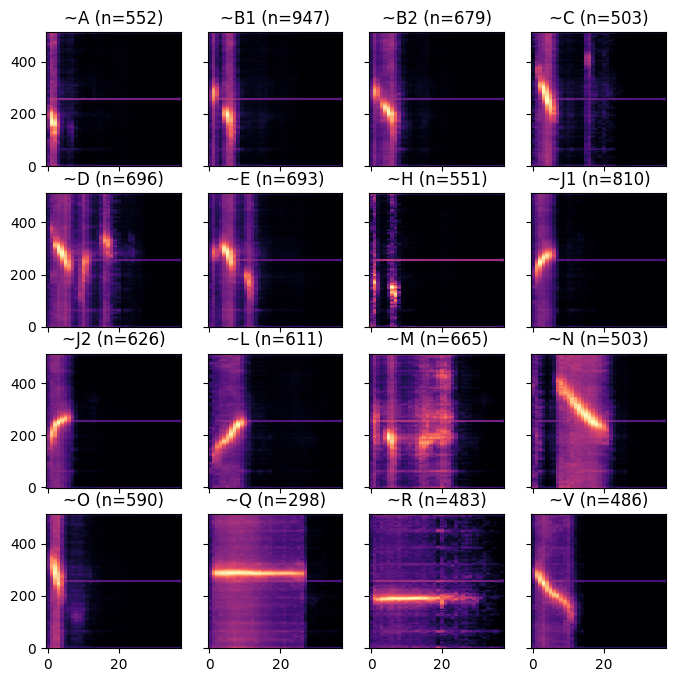

In [88]:
labels = sorted(gen_df["hdbscan_remap"].unique())
labels.remove("X")

n = len(labels)
n_cols = 4
n_rows = n // 4 + int(n % 4 > 0)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    q = gen_df.query("hdbscan_remap==@lbl")
    ax.imshow(
        np.mean(q.spec.values, axis=0),
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="magma",
    )
    ax.set_title(f"~{lbl} (n={len(q)})")

In [233]:
mixed_df.spec = pd.concat([df.spec, gdf.spec])

622


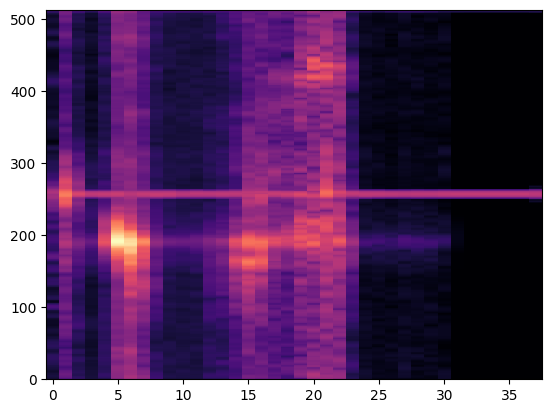

In [235]:
q = mixed_df.query("embed_x >= -15 and embed_x <= -5 and embed_y >= -5 and embed_y <= 5 and kind=='gen'")
print(len(q))
plt.imshow(np.mean(q.spec.values, axis=0), aspect="auto", origin="lower", interpolation="none", cmap="magma")